In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
pd.options.mode.chained_assignment = None
import collections

In this notebook, I'm having a little bit of fun trying to analyze data and see if back to back games in hockey really is that impactful on team results. 

Of course this is only based on factual data. Obviously, rest and injuries can be factors (especially on B2B nights) but crosby won't tell me how he feels before every game :(

I am using hockey reference as my data source.

I'll show step by step how to pull game results when team played on 0 days of rest.

In [3]:
url = "https://www.hockey-reference.com/leagues/NHL_2023_games.html#"
dfs = pd.read_html(url)
df = dfs[0]
df

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
0,2022-10-07,San Jose Sharks,1,Nashville Predators,4,NaN,16648,2:43,"at (Prague, CZ)"
1,2022-10-08,Nashville Predators,3,San Jose Sharks,2,NaN,17023,2:33,"at (Prague, CZ)"
2,2022-10-11,Vegas Golden Knights,4,Los Angeles Kings,3,NaN,18230,2:31,NaN
3,2022-10-11,Tampa Bay Lightning,1,New York Rangers,3,NaN,18006,2:21,NaN
4,2022-10-12,Seattle Kraken,4,Anaheim Ducks,5,OT,17530,2:28,NaN
...,...,...,...,...,...,...,...,...,...
1307,2023-04-13,Vegas Golden Knights,3,Seattle Kraken,1,NaN,17151,2:32,NaN
1308,2023-04-13,Detroit Red Wings,0,Tampa Bay Lightning,5,NaN,19092,2:22,NaN
1309,2023-04-13,New Jersey Devils,5,Washington Capitals,4,OT,18573,2:33,NaN
1310,2023-04-14,Buffalo Sabres,5,Columbus Blue Jackets,2,NaN,18786,2:15,NaN


Our first data frame consists of all the games of the 2022-2023 nhl season.

Let's trim our data only with the essential columns and baptize the unamed column. Since we want to calculate the point % of each team on back to back nights, we'll need the date, results and if the game ended in regulation or past regulation time. 

In [4]:
#df = df[['Date', 'Visitor', 'G', 'Home', 'G.1', 'Unnamed']]

df = df.rename(columns={ "Unnamed: 5" : "OT/SO" })

df = df.iloc[:, :6]

df

,Date,Visitor,G,Home,G.1,OT/SO
0,2022-10-07,San Jose Sharks,1,Nashville Predators,4,NaN
1,2022-10-08,Nashville Predators,3,San Jose Sharks,2,NaN
2,2022-10-11,Vegas Golden Knights,4,Los Angeles Kings,3,NaN
3,2022-10-11,Tampa Bay Lightning,1,New York Rangers,3,NaN
4,2022-10-12,Seattle Kraken,4,Anaheim Ducks,5,OT
...,...,...,...,...,...,...
1307,2023-04-13,Vegas Golden Knights,3,Seattle Kraken,1,NaN
1308,2023-04-13,Detroit Red Wings,0,Tampa Bay Lightning,5,NaN
1309,2023-04-13,New Jersey Devils,5,Washington Capitals,4,OT
1310,2023-04-14,Buffalo Sabres,5,Columbus Blue Jackets,2,NaN


Let's try with the Anaheim Ducks

In [5]:
df = df.loc[(df['Visitor'] == 'Anaheim Ducks') | (df['Home'] == 'Anaheim Ducks')]

df 

,Date,Visitor,G,Home,G.1,OT/SO
4,2022-10-12,Seattle Kraken,4,Anaheim Ducks,5,OT
30,2022-10-15,Anaheim Ducks,1,New York Islanders,7,NaN
43,2022-10-17,Anaheim Ducks,4,New York Rangers,6,NaN
50,2022-10-18,Anaheim Ducks,2,New Jersey Devils,4,NaN
58,2022-10-20,Anaheim Ducks,1,Boston Bruins,2,SO
...,...,...,...,...,...,...
1237,2023-04-05,Edmonton Oilers,3,Anaheim Ducks,1,NaN
1254,2023-04-08,Anaheim Ducks,4,Arizona Coyotes,5,OT
1270,2023-04-09,Colorado Avalanche,5,Anaheim Ducks,4,OT
1282,2023-04-11,Vancouver Canucks,3,Anaheim Ducks,2,NaN


Using the shift function, we get the second game of a back to back night

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

index = (df['Date'] - df['Date'].shift(1)).dt.days == 1
    
df = df.loc[index]

df

,Date,Visitor,G,Home,G.1,OT/SO
50,2022-10-18,Anaheim Ducks,2,New Jersey Devils,4,NaN
189,2022-11-06,Florida Panthers,5,Anaheim Ducks,3,NaN
393,2022-12-04,Anaheim Ducks,2,Winnipeg Jets,5,NaN
461,2022-12-13,Anaheim Ducks,0,Toronto Maple Leafs,7,NaN
515,2022-12-21,Minnesota Wild,4,Anaheim Ducks,1,NaN
705,2023-01-17,Anaheim Ducks,2,Philadelphia Flyers,5,NaN
809,2023-02-07,Anaheim Ducks,3,Chicago Blackhawks,2,OT
911,2023-02-21,Anaheim Ducks,1,Tampa Bay Lightning,6,NaN
1020,2023-03-08,Anaheim Ducks,2,Vancouver Canucks,3,OT
1216,2023-04-02,Anaheim Ducks,4,Calgary Flames,5,NaN


Using our current data frame, we need to calculate if the ducks won, loss in regulation or loss in extra time.

In [7]:
def check_win(row):
    return ((row['Visitor'] == 'Anaheim Ducks') & (row['G'] - row['G.1'] > 0)) or \
           ((row['Home'] == 'Anaheim Ducks') & (row['G'] - row['G.1'] < 0))

def check_loss_in_extra_time(row):
    return ((row['Visitor'] == 'Anaheim Ducks') & (row['G'] - row['G.1'] < 0) & (row['OT/SO'] == "OT" or row['OT/SO'] == "SO")) or \
           ((row['Home'] == 'Anaheim Ducks') & (row['G'] - row['G.1'] > 0) & (row['OT/SO'] == "OT" or row['OT/SO'] == "SO"))

df['result'] = df.apply(lambda row: 'win' if check_win(row) else ('loss_in_extra_time' if check_loss_in_extra_time(row) else 'loss'), axis=1)

df

,Date,Visitor,G,Home,G.1,OT/SO,result
50,2022-10-18,Anaheim Ducks,2,New Jersey Devils,4,NaN,loss
189,2022-11-06,Florida Panthers,5,Anaheim Ducks,3,NaN,loss
393,2022-12-04,Anaheim Ducks,2,Winnipeg Jets,5,NaN,loss
461,2022-12-13,Anaheim Ducks,0,Toronto Maple Leafs,7,NaN,loss
515,2022-12-21,Minnesota Wild,4,Anaheim Ducks,1,NaN,loss
705,2023-01-17,Anaheim Ducks,2,Philadelphia Flyers,5,NaN,loss
809,2023-02-07,Anaheim Ducks,3,Chicago Blackhawks,2,OT,win
911,2023-02-21,Anaheim Ducks,1,Tampa Bay Lightning,6,NaN,loss
1020,2023-03-08,Anaheim Ducks,2,Vancouver Canucks,3,OT,loss_in_extra_time
1216,2023-04-02,Anaheim Ducks,4,Calgary Flames,5,NaN,loss


In [8]:
result_counts = df['result'].value_counts()

result_counts

loss                  8
loss_in_extra_time    2
win                   1
Name: result, dtype: int64

Finally, calculate point % :

11 games played = 22 possible points

8 loss = 0 points

2 loss in extra time = 2 points

1 win = 2 points

Anaheim ducks points % = 4/22 = 0.1818

In [9]:
b2b_point_percentage = 0

b2b_GP = (result_counts.loss + result_counts.loss_in_extra_time + result_counts.win)

if result_counts.win > 0:
    b2b_point_percentage += (result_counts.win * 2)

if result_counts.loss_in_extra_time > 0:
    b2b_point_percentage += result_counts.loss_in_extra_time 
    
b2b_point_percentage /= (b2b_GP * 2)

print(b2b_point_percentage)

0.18181818181818182


Now, for the whole league:

In [10]:
#dictionary to keep track of every team's back to back points %
teams_b2b_dict = {"Anaheim Ducks" : 0, "Arizona Coyotes" : 0, "Boston Bruins" : 0, "Buffalo Sabres" : 0, "Calgary Flames" : 0, "Carolina Hurricanes" : 0, "Chicago Blackhawks" : 0, "Colorado Avalanche" : 0, "Columbus Blue Jackets" : 0, "Dallas Stars" : 0, "Detroit Red Wings" : 0, "Edmonton Oilers" : 0, "Florida Panthers" : 0, "Los Angeles Kings" : 0, "Minnesota Wild" : 0, "Montreal Canadiens" : 0, "Nashville Predators" : 0, "New Jersey Devils" : 0, "New York Islanders" : 0, "New York Rangers" : 0, "Ottawa Senators" : 0, "Philadelphia Flyers" : 0, "Pittsburgh Penguins" : 0, "St. Louis Blues" : 0, "San Jose Sharks" : 0, "Seattle Kraken" : 0, "Tampa Bay Lightning" : 0, "Toronto Maple Leafs" : 0, "Vancouver Canucks" : 0, "Vegas Golden Knights" : 0, "Washington Capitals" : 0, "Winnipeg Jets" : 0}

url2 = "https://www.hockey-reference.com/leagues/NHL_2023_games.html#"
dfs2 = pd.read_html(url)
df2 = dfs[0]

df2 = df2.rename(columns={ "Unnamed: 5" : "OT/SO" })

df2 = df2.iloc[:, :6]

def check_win(row):
    return ((row['Visitor'] == team) & (row['G'] - row['G.1'] > 0)) or \
            ((row['Home'] == team) & (row['G'] - row['G.1'] < 0))

def check_loss_in_extra_time(row):
    return ((row['Visitor'] == team) & (row['G'] - row['G.1'] < 0) & (row['OT/SO'] == "OT" or row['OT/SO'] == "SO")) or \
            ((row['Home'] == team) & (row['G'] - row['G.1'] > 0) & (row['OT/SO'] == "OT" or row['OT/SO'] == "SO"))


for team in teams_b2b_dict:
    
    tmp = df2.loc[(df2['Visitor'] == team) | (df2['Home'] == team)]
    
    tmp['Date'] = pd.to_datetime(tmp['Date'])

    index = (tmp['Date'] - tmp['Date'].shift(1)).dt.days == 1
    
    tmp = tmp.loc[index]
    
    tmp['results'] = tmp.apply(lambda row: 'win' if check_win(row) else ('loss_in_extra_time' if check_loss_in_extra_time(row) else 'loss'), axis=1)

    results = tmp['results'].value_counts()
    
    if results.nunique() == 2:
        results.loss_in_extra_time = 0
    
    point_percentage = 0

    GP = (results.loss + results.loss_in_extra_time + results.win)

    if results.win > 0:
        point_percentage += (results.win * 2)

    if results.loss_in_extra_time > 0:
        point_percentage += results.loss_in_extra_time 
    
    teams_b2b_dict[team] = point_percentage / (GP * 2)
    
teams_b2b_dict

{'Anaheim Ducks': 0.18181818181818182,
 'Arizona Coyotes': 0.3333333333333333,
 'Boston Bruins': 0.7857142857142857,
 'Buffalo Sabres': 0.43333333333333335,
 'Calgary Flames': 0.75,
 'Carolina Hurricanes': 0.8333333333333334,
 'Chicago Blackhawks': 0.17857142857142858,
 'Colorado Avalanche': 0.8076923076923077,
 'Columbus Blue Jackets': 0.29411764705882354,
 'Dallas Stars': 0.4,
 'Detroit Red Wings': 0.43333333333333335,
 'Edmonton Oilers': 0.6,
 'Florida Panthers': 0.3333333333333333,
 'Los Angeles Kings': 0.6818181818181818,
 'Minnesota Wild': 0.5833333333333334,
 'Montreal Canadiens': 0.46153846153846156,
 'Nashville Predators': 0.5,
 'New Jersey Devils': 0.75,
 'New York Islanders': 0.5666666666666667,
 'New York Rangers': 0.5625,
 'Ottawa Senators': 0.5416666666666666,
 'Philadelphia Flyers': 0.16666666666666666,
 'Pittsburgh Penguins': 0.4,
 'St. Louis Blues': 0.4642857142857143,
 'San Jose Sharks': 0.2857142857142857,
 'Seattle Kraken': 0.625,
 'Tampa Bay Lightning': 0.266666666

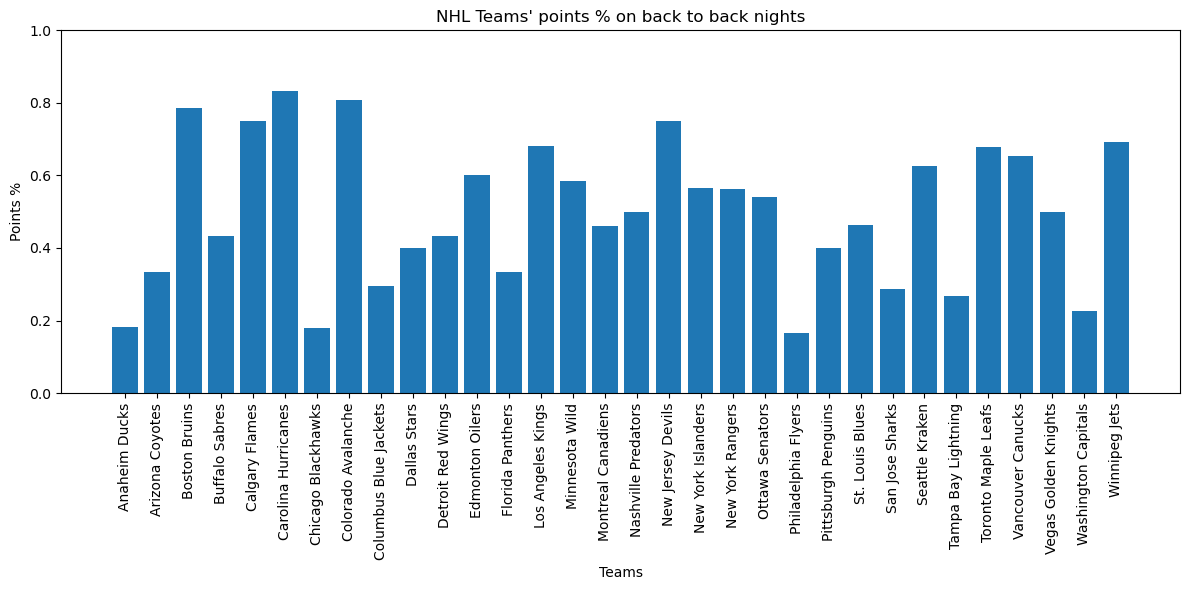

In [11]:
name_list = []
pts_list = []


for team in teams_b2b_dict:
    name_list.append(team)
    pts_list.append(teams_b2b_dict[team])

plt.figure(figsize=(12, 6)) 
plt.bar(name_list, pts_list)

plt.title("NHL Teams' points % on back to back nights")
plt.xlabel("Teams")
plt.ylabel("Points %")

plt.xticks(rotation=90)  
plt.ylim(0, 1)  

plt.tight_layout()  # To prevent labels from being cut off
plt.show()


In [12]:
url3 = 'https://www.hockey-reference.com/leagues/NHL_2023.html#stats'
dfs3 = pd.read_html(url3)
df3 = dfs3[0]
df3 = df3.iloc[:, [0,6]]

df4 = dfs3[1]
df4 = df4.iloc[:, [0,6]]

team_wins_dict = dict(zip(df3.iloc[:, 0], df3.iloc[:, 1]))

team_wins_dict2 = dict(zip(df4.iloc[:, 0], df4.iloc[:, 1]))

team_wins_dict.update(team_wins_dict2)

keys_to_remove = ["Atlantic Division", "Metropolitan Division", "Central Division", "Pacific Division"]

for key in keys_to_remove:
    team_wins_dict.pop(key, None)
    
for k, v in team_wins_dict.items():
    team_wins_dict[k] = float(v)

    
team_wins_dict = collections.OrderedDict(sorted(team_wins_dict.items()))

team_wins_dict


OrderedDict([('Anaheim Ducks', 0.354),
             ('Arizona Coyotes', 0.427),
             ('Boston Bruins*', 0.823),
             ('Buffalo Sabres', 0.555),
             ('Calgary Flames', 0.567),
             ('Carolina Hurricanes*', 0.689),
             ('Chicago Blackhawks', 0.36),
             ('Colorado Avalanche*', 0.665),
             ('Columbus Blue Jackets', 0.36),
             ('Dallas Stars*', 0.659),
             ('Detroit Red Wings', 0.488),
             ('Edmonton Oilers*', 0.665),
             ('Florida Panthers*', 0.561),
             ('Los Angeles Kings*', 0.634),
             ('Minnesota Wild*', 0.628),
             ('Montreal Canadiens', 0.415),
             ('Nashville Predators', 0.561),
             ('New Jersey Devils*', 0.683),
             ('New York Islanders*', 0.567),
             ('New York Rangers*', 0.652),
             ('Ottawa Senators', 0.524),
             ('Philadelphia Flyers', 0.457),
             ('Pittsburgh Penguins', 0.555),
             ('S

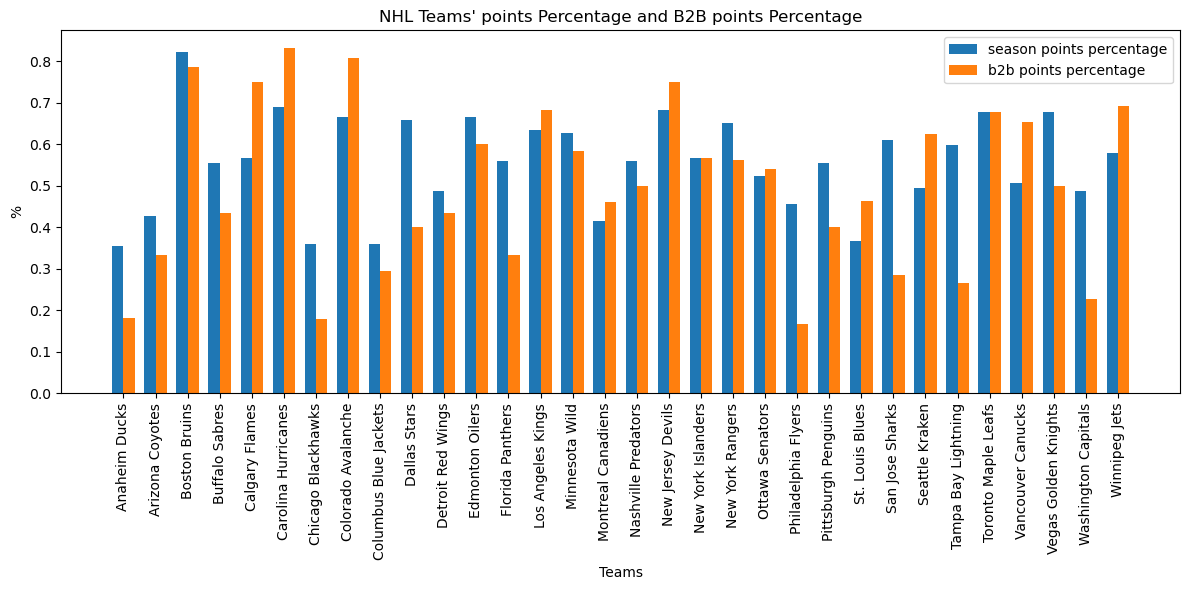

In [13]:
win_per_list = []

for team in team_wins_dict:
    win_per_list.append(team_wins_dict[team])

# Plotting the data
width = 0.35  
x = np.arange(len(name_list)) 

fig, ax = plt.subplots(figsize=(12, 6))  

# Plotting win percentage bars
win_bars = ax.bar(x - width/2, win_per_list, width, label='season points percentage')

# Plotting b2b win percentage bars
pass_bars = ax.bar(x + width/2, pts_list, width, label='b2b points percentage')

ax.set_title("NHL Teams' points Percentage and B2B points Percentage")
ax.set_xlabel("Teams")
ax.set_ylabel("%")

ax.set_xticks(x)
ax.set_xticklabels(name_list, rotation=90)

ax.legend()

plt.tight_layout()
plt.show()
